In [1]:
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from kdd_oh_set import ohkdd
from cnn_model import CNet

In [2]:
# %%time
use_gpu = torch.cuda.is_available()
train_data = ohkdd(test_size=0, use_gpu=use_gpu, data_path='final_train.npy', return_type=2)
# valid_data = train_data.get_valid()
test_data = ohkdd(test_size=0, use_gpu=use_gpu, data_path='final_test.npy',
                  tar_path='kdd99_oh_label_corrected.npy', return_type=2)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
# valid_loader = DataLoader(valid_data, batch_size=100, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=200, shuffle=True, drop_last=True)

print("use_gpu:{}".format(use_gpu))

use_gpu:True
Wall time: 50.9 s


In [3]:
net = CNet()
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

In [4]:
def accuracy(net, input_loader):
    tp = tn = fp = fn = 0
    for x, y in input_loader:
        batch_x = Variable(x)
        batch_y = Variable(y)
        out = net(batch_x)
        res = torch.max(out, 1)[1]

        for i in range(0, len(batch_y)):
            if res[i] == batch_y[i]:
                if res[i] == 1:
                    tp += 1
                else:
                    tn += 1
            else:
                if batch_y[i] == 1:
                    fp += 1
                else:
                    fn += 1
    ac = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return [ac, precision, recall, f1]

In [5]:
# %%time
loss_count = []
acc_count = []
if use_gpu:
    net = net.cuda()
    loss_func = loss_func.cuda()
print("training start...")
for epoch in range(5):
    for i, (x, y) in enumerate(train_loader):
        batch_x = Variable(x)
        batch_y = Variable(y)

        out = net(batch_x)  #模型输出
        loss = loss_func(out, batch_y)  #损失计算

        opt.zero_grad()  #消除旧值
        loss.backward()  #回传
        opt.step()  #更新模型参数

        if i % 5000 == 0:  #打点输出
            # loss_count.append(loss)
            print("{}th{}:\t".format(epoch + 1, i), loss.item())
            acc = accuracy(net, test_loader)
            acc_count.append(acc)
            print("acc:\t{}\nprecision:\t{}\nrecal:\t{}\nF1:\t{}".format(*acc))

    torch.save(net, r'kdd_cnn')  #存储模型

training start...
1th0:	 0.7108801603317261
acc:	0.3809742765273312
precision:	0.24074835772617456
recal:	0.9618833365243474
F1:	0.3851084828372582
1th10000:	 0.028685368597507477
acc:	0.910524115755627
precision:	0.9389887905180642
recal:	0.949334636068539
F1:	0.9441333716123566
1th20000:	 0.0005651567480526865
acc:	0.9103086816720257
precision:	0.9262010303102911
recal:	0.9609934367541766
F1:	0.943276516306934
1th30000:	 0.01129944808781147
acc:	0.9135434083601286
precision:	0.9427423605897481
recal:	0.949522170023811
F1:	0.9461201195905706
1th40000:	 0.029319947585463524
acc:	0.9152090032154341
precision:	0.9451898885827243
recal:	0.9492840813379858
F1:	0.9472325609316845
2th0:	 0.0012707379646599293
acc:	0.9081318327974277
precision:	0.9111304570068527
recal:	0.9730589615097558
F1:	0.9410769931963529
2th10000:	 0.00021987242507748306
acc:	0.9107331189710611
precision:	0.9121211758175494
recal:	0.9754188321810021
F1:	0.9427086772766293
2th20000:	 4.019458629045403e-06
acc:	0.9125948

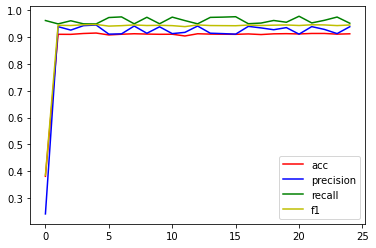

In [6]:
plt.figure('cnn_acc')
acc_count = list(map(list, zip(*acc_count)))
plt.plot(acc_count[0], 'r', label='acc')
plt.plot(acc_count[1], 'b', label='precision')
plt.plot(acc_count[2], 'g', label='recall')
plt.plot(acc_count[3], 'y', label='f1')
plt.legend()
plt.show()

In [7]:
# %%time
acc = accuracy(net, test_loader)
acc_count.append(acc)
print("acc:\t{}\nprecision:\t{}\nrecal:\t{}\nF1:\t{}".format(*acc))

if __name__ == '__main__':
    print('model training end...')

acc:	0.9095434083601286
precision:	0.9131035529305587
recal:	0.9728879906392937
F1:	0.9420482121300763
Wall time: 44.5 s
